In [1]:
import matplotlib.pyplot as plt
import numpy as np
import py21cmfast as p21c
import logging, os
from datetime import datetime

## Set logger to log caching activity

In [2]:
logger = logging.getLogger('21cmFAST')
logger.setLevel(logging.INFO)

## Reset cache location 

In [3]:
p21c.config['direc'] = '/lustre/aoc/projects/hera/wchin/21cmFAST-cache'

## Colorbar function

In [4]:
def colorbar(mappable, plot_color='white'):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.ylabel(f'Neutral Fraction, $x_{{HI}}$', color=plot_color)
    plt.tick_params(color=plot_color, labelcolor=plot_color)
    plt.sca(last_axes)
    
    ax.tick_params(color=plot_color, labelcolor=plot_color)
    
#     for spine in ax.spines.values():  # figure spine color
#         spine.set_edgecolor(plot_color)
        
#     for spine in fig.spines.values():  # figure spine color
#         spine.set_edgecolor(plot_color)
    
    return cbar

## Cosmological Parameters (Default is used when no input is specified)

In [5]:
cosmo_params = p21c.CosmoParams()

## User Parameters, like box length, number of voxels (i.e. resolution) etc.

In [6]:
BOX_LEN=301  # 300, 301
HII_DIM=301  # 450, 301

user_params = p21c.UserParams(
    BOX_LEN=BOX_LEN,  # Box length in Mpc
    DIM=4*HII_DIM,      # Number of Voxels for hight resolution 
    HII_DIM=HII_DIM,  # Number of Voxels for low resolution 
    N_THREADS=os.cpu_count()
)

## Creating initial conditions box

In [7]:
start_time = datetime.now()
print(f'Excution qued at {start_time}')

init_cond = p21c.initial_conditions(
    cosmo_params=cosmo_params,
    user_params=user_params,
    direc='/lustre/aoc/projects/hera/wchin/21cmFAST-cache'
)

end_time = datetime.now()
execution_time = end_time - start_time
print(f'Execution completed at {end_time}')
print(f'Execution time = {execution_time}')

Excution qued at 2021-01-02 17:56:33.865539


2021-01-02 17:58:58,728 | INFO | Existing init_boxes found and read in (seed=230806296593).


Execution completed at 2021-01-02 17:58:58.729987
Execution time = 0:02:24.864448


# Ionized box

In [8]:
illustration_box = p21c.ionize_box(
    redshift=6.5, 
    init_boxes=init_cond,
).xH_box

2021-01-02 17:59:00,540 | INFO | Existing z=6.5 ionized boxes found and read in (seed=230806296593).


In [9]:
# https://terbium.io/2017/12/matplotlib-3d/

from matplotlib import cm

def normalize(arr):
    arr_min = np.min(arr)
    return (arr-arr_min)/(np.max(arr)-arr_min)

def explode(data):
    shape_arr = np.array(data.shape)
    size = shape_arr[:3]*2 - 1
    exploded = np.zeros(np.concatenate([size, shape_arr[3:]]), dtype=data.dtype)
    exploded[::2, ::2, ::2] = data
    return exploded

def expand_coordinates(indices):
    x, y, z = indices
    x[1::2, :, :] += 1
    y[:, 1::2, :] += 1
    z[:, :, 1::2] += 1
    return x, y, z

def plot_cube(cube, angle=-60):
    cube = normalize(cube)
    
    IMG_DIM = np.shape(cube)[0]
    
    facecolors = cm.viridis(cube)
    facecolors[:,:,:,-1] = cube
    facecolors = explode(facecolors)
    
    filled = facecolors[:,:,:,-1] != 0
    x, y, z = expand_coordinates(np.indices(np.array(filled.shape) + 1))

    fig = plt.figure(figsize=(8, 8), dpi=300)
    ax = fig.gca(projection='3d')
    ax.view_init(30, angle)
    ax.set_xlim(right=IMG_DIM*2)
    ax.set_ylim(top=IMG_DIM*2)
    ax.set_zlim(top=IMG_DIM*2)
    ax.set_axis_off()
    ax.set_facecolor('#404040')
    
    ax.voxels(x, y, z, filled, facecolors=facecolors, shade=True)
#     plt.show()
    plt.savefig('/lustre/aoc/projects/hera/wchin/3Dimage')
    
    return fig, ax

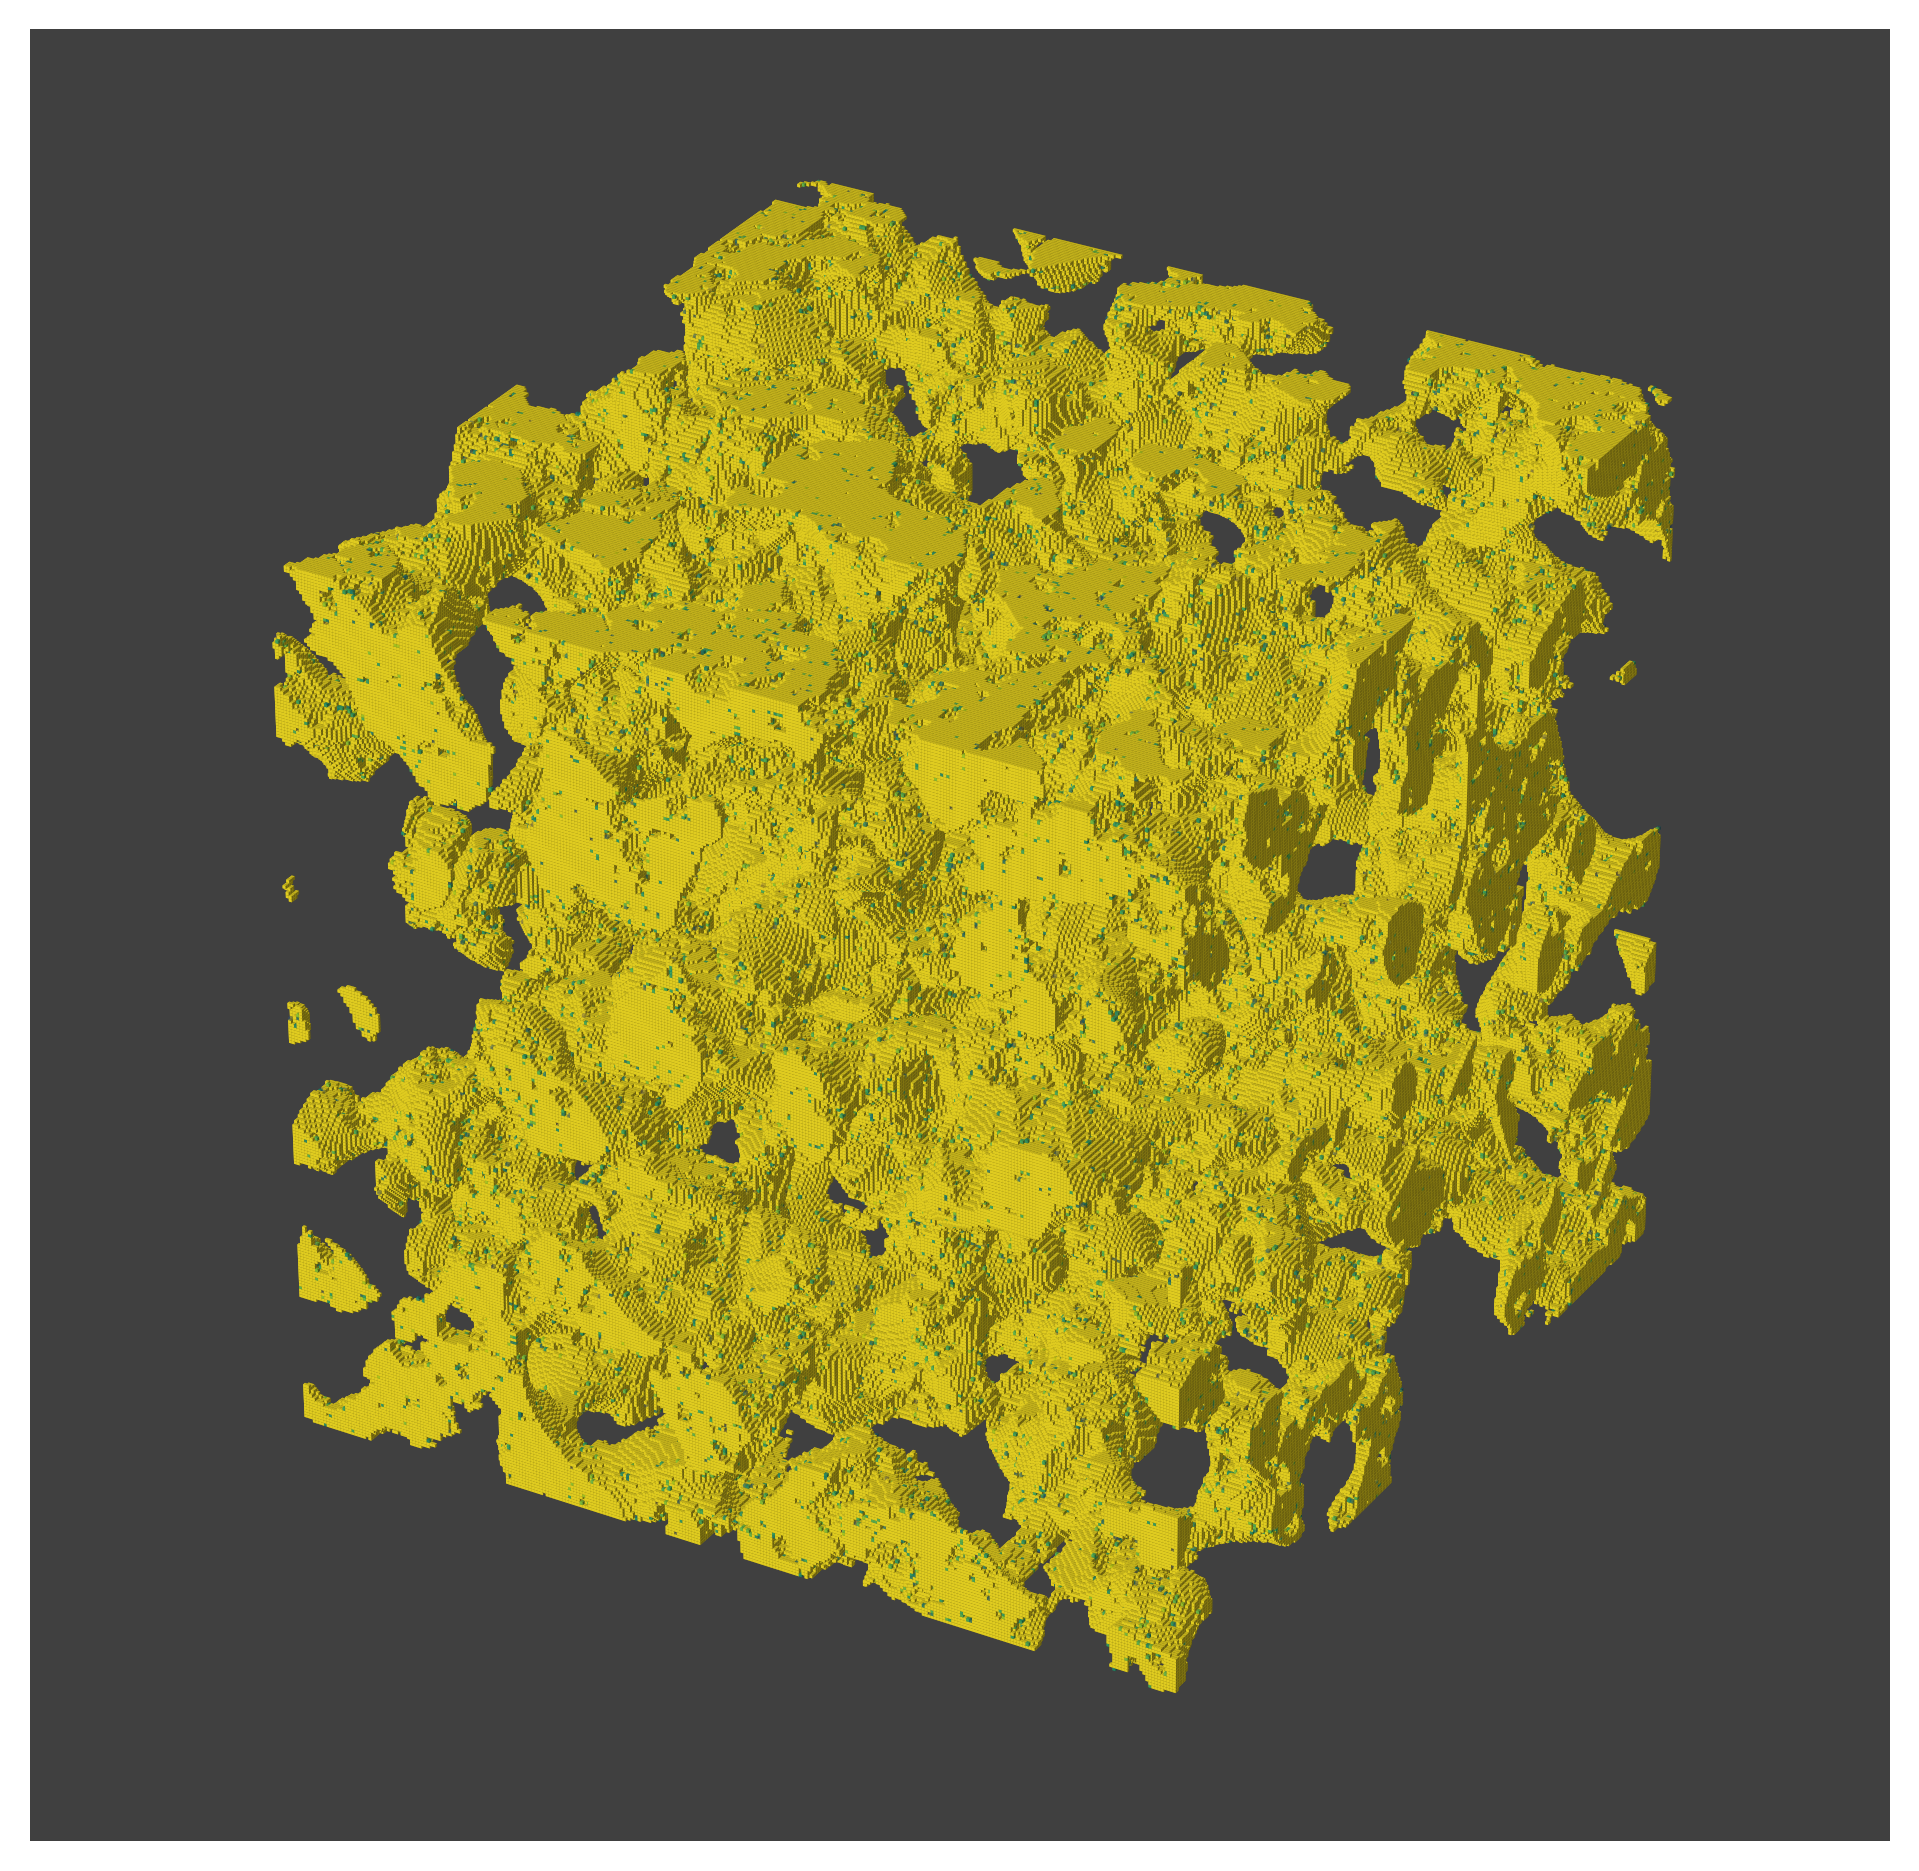

In [10]:
fig, ax = plot_cube(illustration_box)
plt.show()

cube = np.copy(illustration_box)

for x in range(0, BOX_LEN):
    for y in range(0, BOX_LEN):
        for z in range(max(x-y+5, 0), BOX_LEN):
            cube[x, y, z] = 0
plot_cube(cube, angle=200)

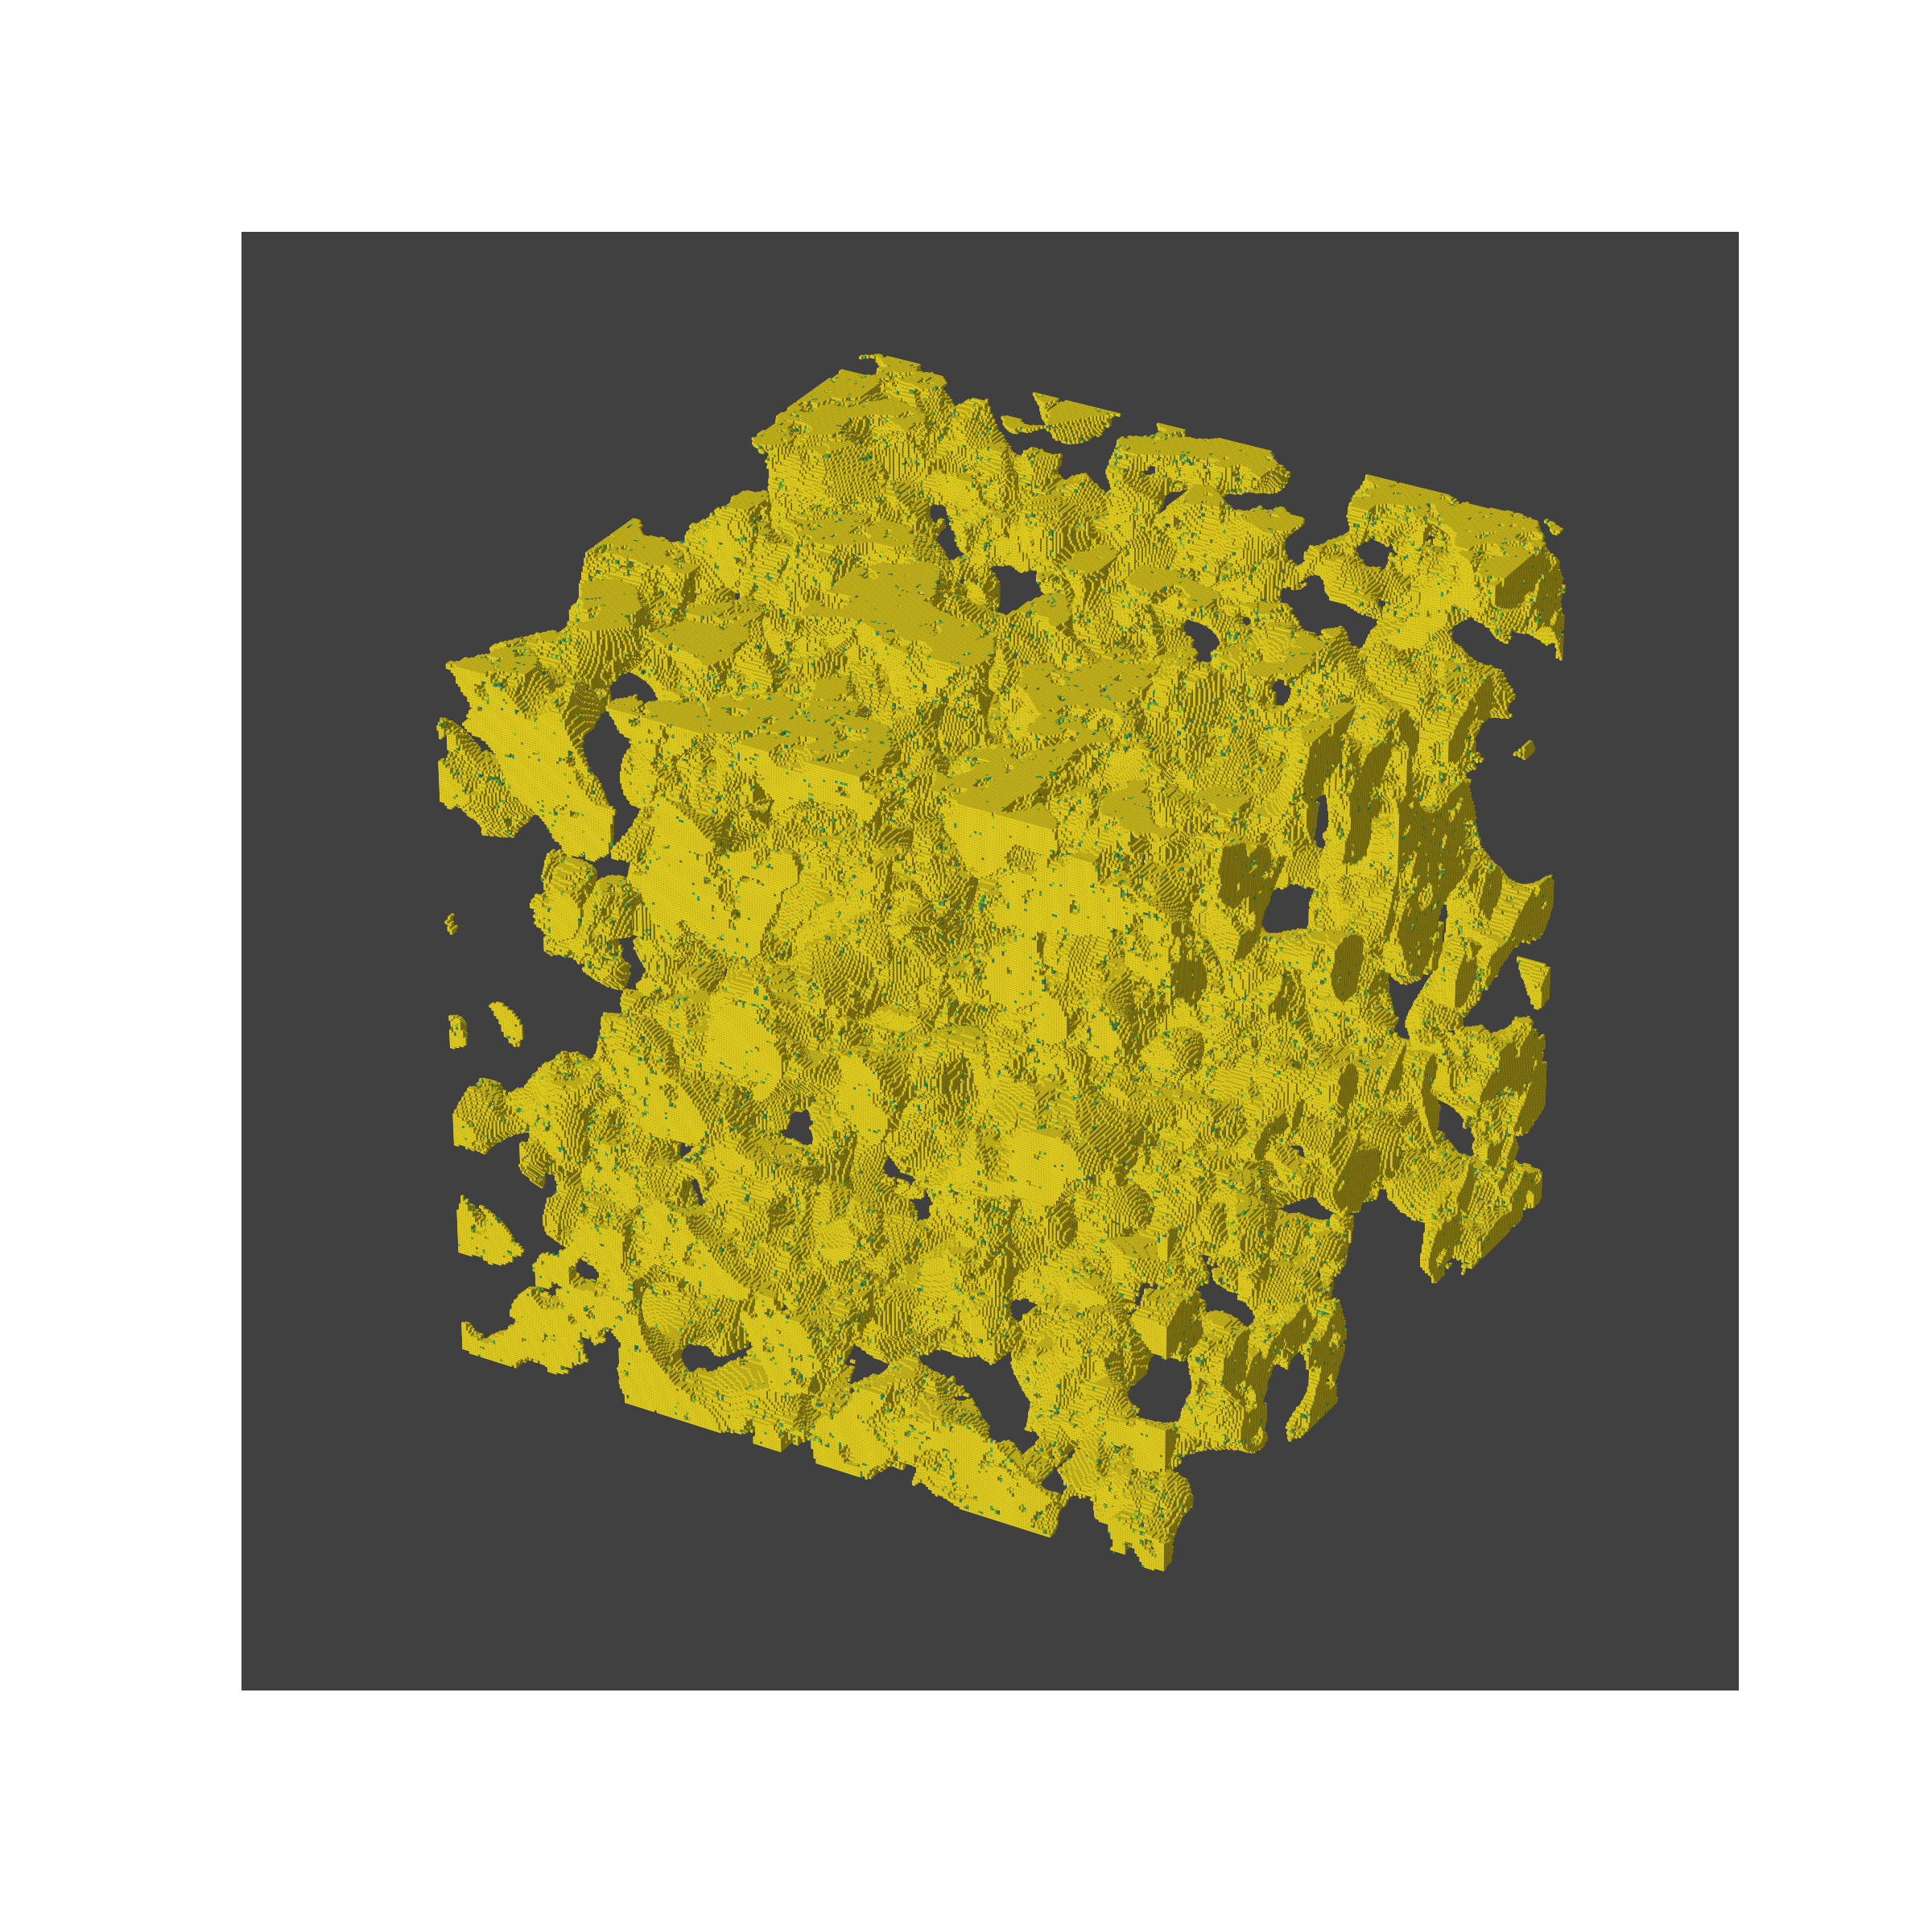

In [11]:
from IPython.display import Image
Image('/lustre/aoc/projects/hera/wchin/3Dimage.png')